In [1]:
import spacy
import numpy as np
import pandas as pd
from collections import Counter
from wordfreq import word_frequency
import scipy
from scipy import stats
import matplotlib.pyplot as plt 

C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [2]:
nlp = spacy.load("en_core_web_sm")

In [22]:
header_names = ['HIT ID', 'Sentence', 'Start word', 'End word', 'Target word', 'Native', 'Non-native', 'Difficult native',
         'Difficult non', 'Binary', 'Prob']

In [23]:
tsv_data = pd.read_csv('data/original/english/WikiNews_Train.tsv', sep='\t', header = 0, names = header_names)

## Question 6

#### 6a) What do the start and offset values refer to? Provide an example. 

In [24]:
#target word of row 0 is 'approves'; start=31, offset=39
ex = tsv_data['Sentence'][0]
ex[31:39]

'approves'

Thus the start value refers to the first character in the string of the target word. The offset value refers to the last character + 1 of the target word.

#### 6b) What does it mean if a target word has a probabilistic label of 0.4?

probabilistic label = the number of annotators who marked the word as difficult / the total number of annotators.

So it is the ratio of annotators who marked it difficult to the total number of annotators.

#### 6c) The dataset was annotated by native and non-native speakers. How do the binary and the probabilistic complexity label account for this distinction? 

They do not account for this distinction:
    
1. For binary: if either a native or non-native speaker marks the target word as difficult, the label is set to 1, and zero otherwise.
2. For probabilistic: no distinction is made between marked as difficult by native and non-native speakers. Both are counted in the numerator (and the total number of annotators is counted for the denominator).

## Question 7 

In [27]:
data = tsv_data[['Target word','Binary','Prob']]

In [28]:
data.head()

,Target word,Binary,Prob
0,approves,1,0.05
1,Supreme,0,0.00
2,Court,0,0.00
3,approves impeachment,1,0.05
4,impeachment,1,0.90


In [29]:
data['Binary'].describe()

count    7745.000000
mean        0.415107
std         0.492772
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Binary, dtype: float64

In [30]:
data.isnull().sum()

Target word    0
Binary         0
Prob           0
dtype: int64

In [31]:
data['Binary'].value_counts()

0    4530
1    3215
Name: Binary, dtype: int64

In [32]:
data['Prob'].describe()

count    7745.000000
mean        0.083951
std         0.169690
min         0.000000
25%         0.000000
50%         0.000000
75%         0.100000
max         1.000000
Name: Prob, dtype: float64

In [33]:
max_tokens = 0
more_than_one_token = 0
for word in data['Target word']:
    doc = nlp(word)
    if len(doc) > 1:
        more_than_one_token += 1
    if len(doc) > max_tokens:
        max_tokens = len(doc)

print(f'Number of instances with more than one token: {more_than_one_token}')
print(f'Max number of tokens per instance: {max_tokens}')

Number of instances with more than one token: 1086
Max number of tokens per instance: 10


## 8.

In [34]:
'''
At least one native or non-native thought it was difficult
'''
temp_data = tsv_data.loc[(tsv_data["Difficult native"] >= 1) | (tsv_data["Difficult non"] >= 1)]

In [35]:
'''
Fuck pandas
'''
clean = temp_data
lengths = []
for i in range(len(temp_data)):
    if len(clean["Target word"].iloc[i].split(' ')) == 1:
        lengths.append(1)
    else:
        lengths.append(0)

clean['lengths'] = lengths

clean = clean.loc[(clean['lengths'] == 1)]

C:\Users\sebas\AppData\Local\Temp\ipykernel_2332\1724494000.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['lengths'] = lengths


In [36]:
'''
Calculate word length and compute correlation with probabilistic complexity
'''
wordcor = []
postags = []

for i in range(len(clean)):
    
    #pos tagging
    for token in nlp(clean['Sentence'].iloc[i]):
        if token.text ==clean['Target word'].iloc[i]:
            pos=token.pos_
            postags.append([pos, clean['Prob'].iloc[i]])
            break
                
    wordcor.append([len(clean['Target word'].iloc[i]), 
                    word_frequency(clean['Target word'].iloc[i], 'en', minimum = 0.0),
                    clean['Prob'].iloc[i]])


KeyboardInterrupt: 

In [ ]:
# x is word length, y is probabilistic complexity
word_length = np.array(wordcor).T[0]
word_freq = np.array(wordcor).T[1]
prob_complex = np.array(wordcor).T[2]

In [ ]:
print(f"Pearson Correlation length vs complexity: {scipy.stats.pearsonr(word_length, prob_complex)[0]}, p = {scipy.stats.pearsonr(word_length, prob_complex)[1]}")
print(f"Pearson Correlation frequency vs complexity: {scipy.stats.pearsonr(word_freq, prob_complex)[0]}, p = {scipy.stats.pearsonr(word_freq, prob_complex)[1]}")

In [ ]:
plt.scatter(word_length, prob_complex)
plt.title("Plot between words length and  probabilistic complexity")
plt.xlabel("Word length")
plt.ylabel("Probabilistic Complexity")
plt.xticks([0, 5, 10, 15, 20])
plt.show()

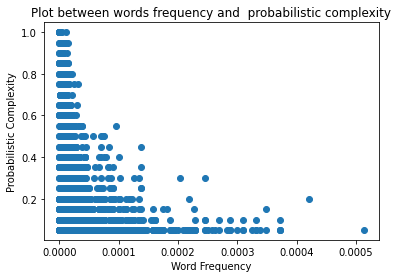

In [11]:
plt.scatter(word_freq, prob_complex)
plt.title("Plot between words frequency and  probabilistic complexity")
plt.xlabel("Word Frequency")
plt.ylabel("Probabilistic Complexity")
plt.show()

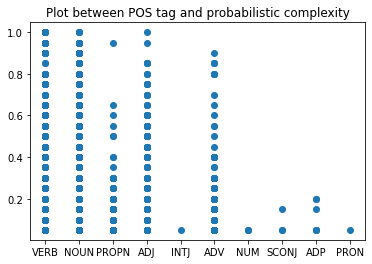

In [12]:
plt.scatter(np.array(postags).T[0], np.array(postags).T[1].astype('float'))
plt.title("Plot between POS tag and probabilistic complexity")
plt.show()

## 9. Reflection

https://www-jstor-org.vu-nl.idm.oclc.org/stable/pdf/26375812.pdf?refreqid=excelsior%3A5d2d12217d4e30d106b3a2d685c9257a&ab_segments=&origin=

We have only looked at single token linguisttic characeristics to determine complexity. However, according to the article above, complexity often arises when the word is part of a certain construct. It might therefore be useful to determine whether a word is or isn't part of such a construct.

## 10. Baselines

In [35]:
from baselines import Baseliner
import numpy as np
import matplotlib.pyplot as plt

C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [38]:
analyzer = Baseliner()
runs = 1000

### Majority Baseline

In [39]:
analyzer.set_mode("test")

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.25398633, 0.35398633, 0.45398633, 0.55398633, 0.65398633,
        0.75398633, 0.85398633, 0.95398633, 1.05398633, 1.15398633,
        1.25398633]),
 <BarContainer object of 10 artists>)

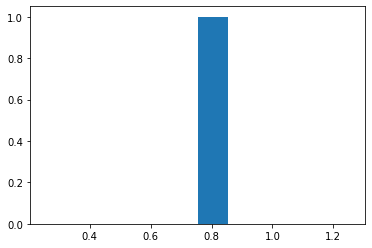

In [40]:
ans = np.zeros(runs)
for i in range(runs):
    ans = analyzer.majority_baseline()[0]
plt.hist(ans)

In [41]:
np.mean(ans)

0.7539863325740319

In [42]:
analyzer.set_mode("dev")

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([0.30655391, 0.40655391, 0.50655391, 0.60655391, 0.70655391,
        0.80655391, 0.90655391, 1.00655391, 1.10655391, 1.20655391,
        1.30655391]),
 <BarContainer object of 10 artists>)

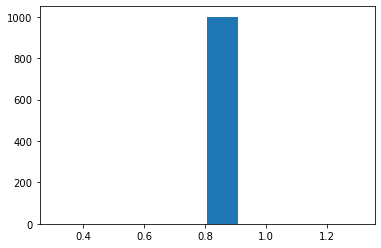

In [43]:
ans = np.zeros(runs)
for i in range(runs):
    ans[i] = analyzer.majority_baseline()[0]
plt.hist(ans)

In [44]:
np.mean(ans)

0.8065539112050737

### Random Baseliner

In [45]:
# run monte from carlo
ans = np.zeros(runs)
for i in range(runs):
    ans[i] = analyzer.random_baseline()[0]

(array([  4.,  17.,  50., 136., 235., 249., 191.,  86.,  27.,   5.]),
 array([0.43868922, 0.44603594, 0.45338266, 0.46072939, 0.46807611,
        0.47542283, 0.48276956, 0.49011628, 0.497463  , 0.50480973,
        0.51215645]),
 <BarContainer object of 10 artists>)

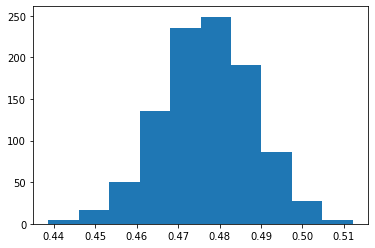

In [12]:
plt.hist(ans)

In [46]:
np.mean(ans)

0.4773683932346723

In [47]:
analyzer.set_mode("dev")

(array([ 10.,  35.,  97., 213., 235., 219., 115.,  52.,  22.,   2.]),
 array([0.44556025, 0.45237844, 0.45919662, 0.4660148 , 0.47283298,
        0.47965116, 0.48646934, 0.49328753, 0.50010571, 0.50692389,
        0.51374207]),
 <BarContainer object of 10 artists>)

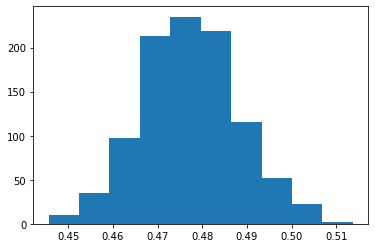

In [48]:
ans = np.zeros(runs)
for i in range(runs):
    ans[i] = analyzer.random_baseline()[0]
plt.hist(ans)

In [49]:
np.mean(ans)

0.47727272727272724

### Length Baseline

In [50]:
analyzer.set_mode("test")

In [51]:
# check for different thresholds
thresholds = [2,3,4,5,6,7,8,9,10,11,12]

In [52]:
ans = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    analyzer.threshold = threshold
    ans[i] = analyzer.length_baseline()[0]

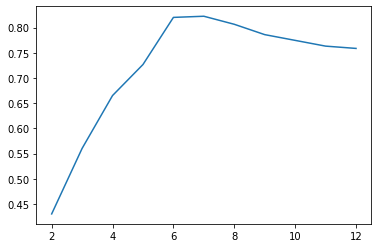

In [21]:
plt.plot(thresholds, ans)

In [22]:
max(ans)

0.8223234624145785

In [53]:
analyzer.set_mode("dev")

In [24]:
ans = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    analyzer.threshold = threshold
    ans[i] = analyzer.length_baseline()[0]

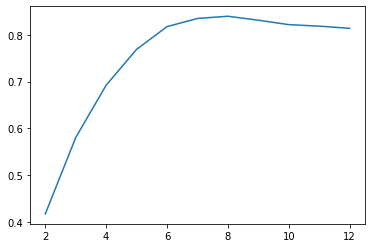

In [25]:
plt.plot(thresholds, ans)

In [14]:
max(ans)

0.8398520084566596

### Frequency

In [54]:
analyzer.set_mode("test")

# check for different thresholds
thresholds = [10e-8, 10e-7, 10e-6, 10e-5,10e-4, 10e-3, 10e-2, 10e-1, 10e-0]

In [55]:
ans = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    analyzer.threshold = threshold
    ans[i] = analyzer.frequency_baseline()[0]

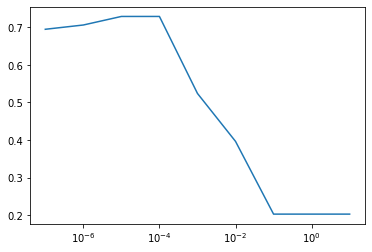

In [28]:
plt.xscale("log")
plt.plot(thresholds, ans)

In [56]:
max(ans)

0.7289293849658315

In [57]:
analyzer.set_mode("dev")

# check for different thresholds
thresholds = [10e-8, 10e-7, 10e-6, 10e-5,10e-4, 10e-3, 10e-2, 10e-1, 10e-0]

In [58]:
ans = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    analyzer.threshold = threshold
    ans[i] = analyzer.frequency_baseline()[0]

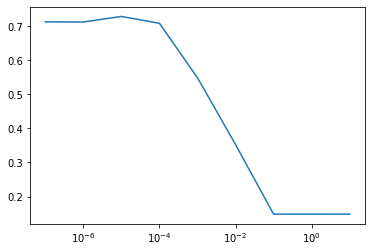

In [32]:
plt.xscale("log")
plt.plot(thresholds, ans)

In [59]:
max(ans)

0.7278012684989429

## F1 scores

In [36]:
analyzer = Baseliner()
analyzer.set_mode("test")

### With sk learn

In [37]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [38]:
def binarize_labels(labels):
    output = []
    for sent in labels:
        for label in sent:
            if label == "C":
                output.append(1)
            elif label == "N":
                output.append(0)
    return output

In [43]:
def sk_f1(gold, predict, pos_label=1, average="binary"):
    gold = binarize_labels(gold)
    predict = binarize_labels(predict)

    return f1_score(gold, predict, pos_label=pos_label,average=average)

def sk_precision(gold, predict, pos_label=1, average="binary"):
    gold = binarize_labels(gold)
    predict = binarize_labels(predict)

    return precision_score(gold, predict, pos_label=pos_label,average=average)

def sk_recall(gold, predict, pos_label=1, average="binary"):
    gold = binarize_labels(gold)
    predict = binarize_labels(predict)

    return recall_score(gold, predict, pos_label=pos_label,average=average)

In [40]:
def get_precision(predicts, labels, target):
    right = 0
    wrong = 0
    i=0
    for predict in predicts:
        if predict == target:
            if predict == labels[i]:
                right +=1
            else:
                wrong +=1
        i+=1
    if (right+wrong) == 0:
        return 0
    return right/(wrong+right)

def get_recall(predicts, labels, target):
    right=0
    wrong=0
    i=0
    for predict in labels:
        if predict == target:
            if predict == predicts[i]:
                right+=1
            else:
                wrong+=1
        i+=1
    if (right+wrong) == 0:
        return 0
    return right/(wrong+right)

def get_f1(predicts, labels, target):
    recall = get_recall(predicts, labels, target)
    precision = get_precision(predicts, labels, target)
    if (precision+recall) == 0:
        return 0
    return 2*(precision*recall)/(precision+recall)

In [41]:
# Random (bootstrap?)
results = analyzer.random_baseline()
target = 1

print("Class C")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

target = 0
print("\nClass N")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

print(f'\nWeighted:{sk_f1(results[1], analyzer.testlabels,pos_label=target, average="weighted")}')


Class C
Precision: 0.449438202247191
0.19900497512437812
Recall: 0.449438202247191
0.449438202247191
F1 0.2758620689655173
0.2758620689655173

Class N
Precision: 0.54
0.7941176470588235
Recall: 0.54
0.54
F1 0.6428571428571429
0.6428571428571429

Weighted:0.4748252297541435


C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [53]:
sk_f1(results[1], analyzer.testlabels,pos_label=target, average="weighted")

C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.8871989860583017

In [52]:
# Majority
results = analyzer.majority_baseline()
target = 1

print("Class C")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

target = 0
print("\nClass N")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

print(f'\nWeighted:{sk_f1(results[1], analyzer.testlabels,pos_label=target, average="weighted")}')


Class C
Precision: 0.0
0
Recall: 0.0
0.0
F1 0.0
0

Class N
Precision: 1.0
0.7972665148063781
Recall: 0.7972665148063781
1.0
F1 0.8871989860583017
0.8871989860583017

Weighted:0.8871989860583017


C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [45]:
# Length
analyzer.threshold=7
results = analyzer.length_baseline()
target = 1

target = 1

print("Class C")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

target = 0
print("\nClass N")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

print(f'\nWeighted:{sk_f1(results[1], analyzer.testlabels,pos_label=target, average="weighted")}')


Class C
Precision: 0.48314606741573035
0.7678571428571429
Recall: 0.7678571428571429
0.48314606741573035
F1 0.5931034482758621
0.5931034482758621

Class N
Precision: 0.9628571428571429
0.8798955613577023
Recall: 0.8798955613577023
0.9628571428571429
F1 0.9195088676671215
0.9195088676671215

Weighted:0.877871729886004


C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [46]:
# frequence
analyzer.threshold=10e-6
results = analyzer.frequency_baseline()

target = 1
print("Class C")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

target = 0
print("\nClass N")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

print(f'\nWeighted:{sk_f1(results[1], analyzer.testlabels,pos_label=target, average="weighted")}')


Class C
Precision: 0.38202247191011235
0.3469387755102041
Recall: 0.3469387755102041
0.38202247191011235
F1 0.36363636363636365
0.36363636363636365

Class N
Precision: 0.8171428571428572
0.8387096774193549
Recall: 0.8387096774193549
0.8171428571428572
F1 0.8277858176555717
0.8277858176555717

Weighted:0.724171588740122


C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


## For NN output

In [47]:
def binarize(labels):
    output = []
    for label in labels:
        if label == "N":
            output.append(0)
        elif label == "C":
            output.append(1)
    return output

In [57]:
import pandas as pd
header_names = ['word', 'gold', 'predict']
data = pd.read_csv('experiments/base_model/model_output.tsv', encoding = 'latin-1', sep='\t', header = 0, names = header_names)
data = data.dropna()

In [58]:
#binarize
data['gold'] = binarize(list(data['gold']))
data['predict'] = binarize(list(data['predict']))

In [71]:
target=0
print("Class N, precision, recall, f1, f1 weighted")

print(f"Precision: {precision_score(data['gold'], data['predict'], pos_label=target)}")
print(f"Recall : {recall_score(data['gold'], data['predict'], pos_label=target)}")
print(f"F1: {f1_score(data['gold'], data['predict'], pos_label=target)}")
average="weighted"
print(f1_score(data['gold'], data['predict'], pos_label=target,average=average))

print()
print("Class C, precision, recall, f1, f1 weighted")
target = 1
print(f"Precision: {precision_score(data['gold'], data['predict'], pos_label=target)}")
print(f"Recall : {recall_score(data['gold'], data['predict'], pos_label=target)}")
print(f"F1: {f1_score(data['gold'], data['predict'], pos_label=target)}")
average="weighted"
f1 = f1_score(data['gold'], data['predict'], pos_label=target,average=average)
print(f1)

Class N, precision, recall, f1, f1 weighted
Precision: 0.8773333333333333
Recall : 0.94
F1: 0.9075862068965517
0.8370064264792215

Class C, precision, recall, f1, f1 weighted
Precision: 0.6666666666666666
Recall : 0.4772727272727273
F1: 0.5562913907284768
0.8370064264792215


C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [73]:
## dataset 2: lstm_hidden dim of 20
data_2 = pd.read_csv('experiments/base_model/model_output.tsv', encoding = 'latin-1', sep='\t', header = 0, names = header_names)
data_2 = data_2.dropna()

data_2['gold'] = binarize(list(data_2['gold']))
data_2['predict'] = binarize(list(data_2['predict']))

f2 = f1_score(data_2['gold'], data_2['predict'], pos_label=target,average=average)
print(f2)

0.8289662151290413


In [74]:
## dataset 3: lstm_hidden of 80
data_3 = pd.read_csv('experiments/base_model/model_output.tsv', encoding = 'latin-1', sep='\t', header = 0, names = header_names)
data_3 = data_3.dropna()

data_3['gold'] = binarize(list(data_3['gold']))
data_3['predict'] = binarize(list(data_3['predict']))

f3 = f1_score(data_3['gold'], data_3['predict'], pos_label=target,average=average)
print(f3)

0.8340737386316465


In [75]:
## dataset 4: lstm_hidden of 150
data_4 = pd.read_csv('experiments/base_model/model_output.tsv', encoding = 'latin-1', sep='\t', header = 0, names = header_names)
data_4 = data_4.dropna()

data_4['gold'] = binarize(list(data_4['gold']))
data_4['predict'] = binarize(list(data_4['predict']))

f4 = f1_score(data_4['gold'], data_4['predict'], pos_label=target,average=average)
print(f4)

0.8228445634115708


Text(0, 0.5, 'F1 score')

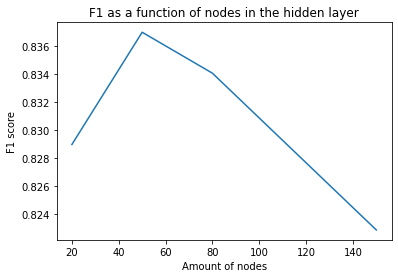

In [84]:
fs = [f2,f1,f3,f4]
nodes = [20, 50, 80, 150]

plt.plot(nodes, fs)
plt.title("F1 as a function of nodes in the hidden layer")
plt.xlabel("Amount of nodes")
plt.ylabel("F1 score")

In [104]:
og_predicts = data['predict'].tolist()
new_predicts = data_2['predict'].tolist()
words = data['word'].tolist()

for i, predict in enumerate(og_predicts):
    if og_predicts[i] != new_predicts[i]:
        print(words[i])
        print(og_predicts[i])
        print(new_predicts[i])

officers
1
0
Here
0
1
met
1
0
ensued
0
1
victims
1
0
violent
0
1
prison
0
1
prison
0
1
riots
0
1
Brazil
1
0
state
1
0
Norte
0
1
2010
0
1
thousands
1
0
WikiLeaks
1
0
detailing
0
1
wars
1
0
scheduled
0
1
suicide
0
1
Eight
1
0
Houston-area
0
1
night
1
0
Texas
1
0
taking
1
0
citizens
1
0
deputies
1
0
arrived
0
1
check
1
0
mere
1
0
commuted
1
0
Manning
0
1
charged
0
1
Maghreb
1
0
al-Mourabitoun
1
0
2021
0
1
winger
1
0
Franck
1
0
contract
1
0
